d:\Users\jg255\anaconda3\envs\ray310\lib\site-packages\scipy\optimize\_trustregion_constr\projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
d:\Users\jg255\anaconda3\envs\ray310\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


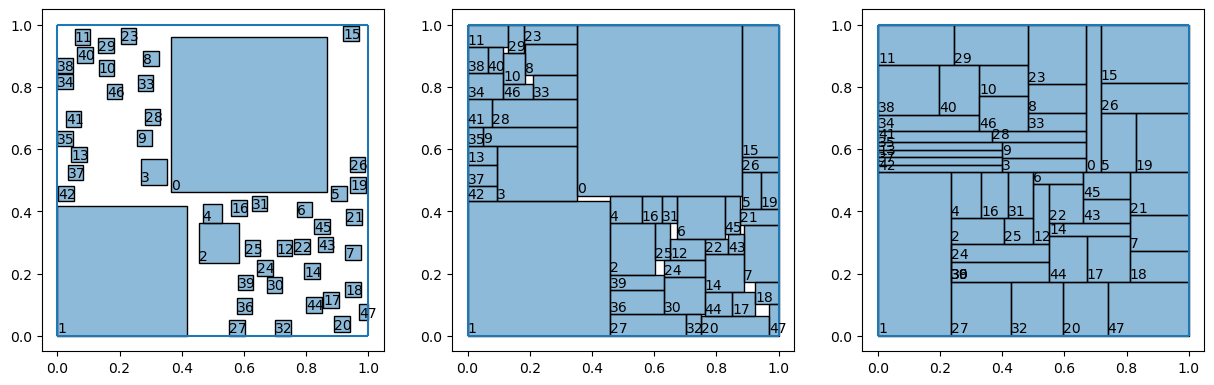

In [1]:
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation(config={'seed' : 123456})
rects.execute(num=200)
rects.prepare_constraints()
rects.close_holes()
rects.draw_closed()

In [2]:
# rects.sol.x.reshape(-1,4)[36]
# rects.clinched_rectangles[:,:4]
rects.sol.fun
# for constrain in rects.const_trust:
#     print(constrain.A.dot(rects.clinched_rectangles[:,:4].flatten()))
# rects.clinched_rectangles.shape
# import numpy as np

# np.maximum(0, rects.clinched_rectangles[8,:4])

1.1812182287314313e+19

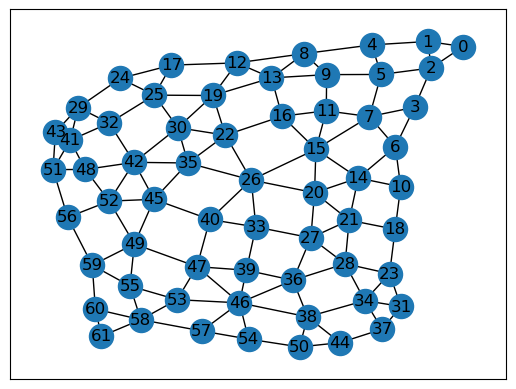

In [21]:
import networkx as nx
G = nx.from_numpy_array(rects.east_neighbours + rects.north_neighbours)
nx.draw_networkx(G)

In [3]:
import numpy as np
pts_diag = np.array(
                 [[0.25, 0.25],
                  [0.75, 0.75]])
def tepui(
        base:float=0.05,
        top:float=0.3,
        slope:float=4,
        vertex:float=1,
        pts:np.ndarray=pts_diag
):
    return lambda pt : np.minimum(top, np.maximum(base, vertex - slope * np.min(np.linalg.norm(pts - pt, axis=1))))

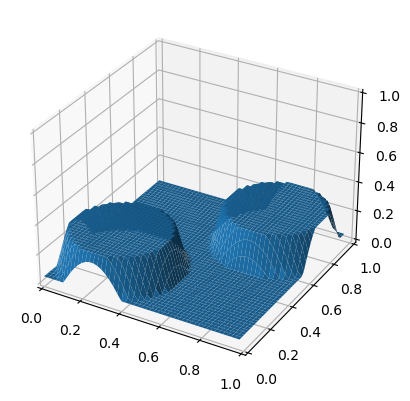

In [6]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

tepui_at = tepui(
        base=0.05,
        top=0.3,
        slope=5,
        vertex=1.5,
)

x = np.arange(0, 1, 0.02)
y = np.arange(0, 1, 0.02)

X, Y = np.meshgrid(x, y)
points = np.array([X,Y])

nu = np.apply_along_axis(tepui_at, 0, points)

fig = plt.figure()
ax:Axes = fig.add_subplot(projection='3d')
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
ax.plot_surface(X, Y, nu)
plt.show()

In [8]:
from SquareDivision.src.generators import uniform_pts
random_points = uniform_pts(n=5)
vals = np.apply_along_axis(tepui_at, 1, random_points)
vals
# rng = np.random.default_rng(1234)
# rng.uniform([xmin, ymin], [xmax, ymax], size=(n, 2))

array([0.4       , 0.05      , 0.05      , 0.05      , 0.36100765])

In [12]:
import numpy as np
norma_a = np.array([[1, 1],[2, 3],[4, 5],[6, 7]]).astype(float)
a=np.ones(shape=(2,2))
# recip_a = np.reciprocal(a)
# np.diagonal(norma_a.T.dot(recip_a)).sum()
# (recip_a**2)*norma_a
# norma_a[:,0] * norma_a[:,1]
type(a[1,1])

numpy.float64